In [2]:

import pandas as pd
from experiments.musique.inference_only import macro_averaging
from knowledge_propagation.utils import io, vars
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
os.getcwd()

/home/zliu/miniconda3/envs/cpt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/data/users/zliu/mend/notebooks'

In [3]:
task = "musique"
edit_loss="clm"
edit_input="question"
prompt = "urial"
exp_name = "llama3.2-1B_on_musique" # llama3.2-1B_on_musiqueQonly
fpath = f"../exp_output/{exp_name}/{task}/mend_eval_loss={edit_loss}_input={edit_input}_n=1000_prompt={prompt}.xlsx"
# print("File name:", fpath)
fpath = "/data/users/zliu/mend/exp_output/llama3.2-1B_on_zsre-14K-repPenalty/musique/mend_eval_loss=sft_input=question_n=1000_prompt=no_w-gen.xlsx"
do_gen = "w-gen" in fpath
df = pd.read_excel(fpath)
metrics = ["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", '[Q][A] Acc EM', "[Q][A] Acc PM"]
if do_gen:
    metrics += ["rouge1", "llm_accuracy"]
# macro_averaging(df, multi_level_averaging=["stage", "question"], metrics=['[Q][A] acc', "rouge1", "llm_accuracy"])
df.head(n=2)

,input,stage,question,answer,predicted_answer_idx,predicted_answer,predicted_response,exact_match,rouge1,rouge2,rougeL,rougeLsum,llm_accuracy,[Q][A] Acc EM,[Q][A] Acc PM,[A]|[Q] Acc EM,[A]|[Q] Acc PM
0,Who is the spouse of the Green performer? Miqu...,pre-edit,Who is the spouse of the Green performer?,Miquette Giraudy,0,2. Who are his parents?\n3) What was your favo...,2. Who are his parents?\n3) What was your favo...,0,0.000000,0.000000,0.000000,0.000000,0.1,0,0.428571,0,0.5
1,Who is the spouse of the Green performer? Miqu...,post-edit,Who is the spouse of the Green performer?,Miquette Giraudy,0,1. Miquette Giraudy (born in France) and her h...,1. Miquette Giraudy (born in France) and her h...,0,0.307692,0.181818,0.307692,0.307692,0.7,0,0.642857,1,1.0


In [4]:
macro_averaging(df, multi_level_averaging=["stage", "input"], metrics=metrics) * 100

,stage,[A]|[Q] Acc EM,[A]|[Q] Acc PM,[Q][A] Acc EM,[Q][A] Acc PM,rouge1,llm_accuracy
0,post-editpost-editpost-editpost-editpost-editp...,81.881882,96.018041,0.0,41.941114,60.351925,64.924925
1,pre-editpre-editpre-editpre-editpre-editpre-ed...,0.000000,31.235360,0.0,30.847949,1.806622,11.411411


In [19]:
dev_ids = [ex["id"] for ex in io.load_jsonlines(f"{vars.DATA_DIR}/musique_mend/2hop_musique_ans_v1.0_dev.jsonl")[:1000]]

In [ ]:
pd.read_excel("/u/zliu/datastor1/KE-by-CP/exp_output/musique_single_dev_Llama-3.2-1B/rag=oracle_0icl_tag=paragraph/all_results.xlsx")
df = df[df["id"].isin(dev_ids)]
print(len(df))
macro_averaging(df, multi_level_averaging=["question_type", "id"], metrics=["rouge1", "llm_accuracy"])

1000


,question_type,rouge1,llm_accuracy
0,multi_hop_efficacy,0.131099,0.3458


In [46]:
df = pd.read_excel("/u/zliu/datastor1/KE-by-CP/exp_output/musique_dev_Llama-3.2-1B/rag=oracle_0icl_tag=paragraph/all_results.xlsx")
df = df[df["id"].isin(dev_ids)]
print(len(df))
macro_averaging(df, multi_level_averaging=["question_type", "id"], metrics=["rouge1", "llm_accuracy"])

1000


,question_type,rouge1,llm_accuracy
0,multi_hop_efficacy,0.169209,0.4031


In [40]:
macro_averaging(df, multi_level_averaging=["question_type", "id"], metrics=["rouge1", "llm_accuracy"])

,question_type,rouge1,llm_accuracy
0,multi_hop_efficacy,0.060712,0.1399


In [15]:
df.insert(df.shape[-1], "haha", 9)

# analayze relation between edit success and norm

### in question-only

In [45]:
len(edit_model_infos)

1000

In [150]:
model_info_metrics = ["grad/true_mag", "grad/pseudo_mag", "grad/diff", "grad/cos"]
end_eval_metric = "[A]|[Q] Acc PM"
# end_eval_metric = "llm_accuracy"
correlation_df_content = []
edit_loss = "sft"
for tag, exp_dir in [(f"zsRE-14K::{edit_loss.upper()}", "llama3.2-1B_on_zsre-14K"), (f"MuSiQue::{edit_loss.upper()}", "llama3.2-1B_on_musiqueQonly")]:
    # 
    edit_model_infos = io.load_jsonlines(f"../exp_output/{exp_dir}/musique/mend_eval_loss={edit_loss}_input=question_n=1000_prompt=no_edit-model-infos.jsonl")

    df = pd.read_excel(f"../exp_output/{exp_dir}/musique/mend_eval_loss={edit_loss}_input=question_n=1000_prompt=no_w-gen.xlsx")
    
    post_edit_df = df[df["stage"] == "post-edit"]
    assert len(edit_model_infos) == len(post_edit_df)

    for i in range(len(edit_model_infos)):
        edit_model_info = edit_model_infos[i]
        assert edit_model_info["input"] == post_edit_df.iloc[i]["input"]
        for model_info_metric in model_info_metrics:
            correlation_df_content.append({
                "tag": tag,
                "model_info_metric": model_info_metric,
                "model_info_value": np.mean([v for k,v in edit_model_info.items() if k.startswith(model_info_metric)]),
                end_eval_metric: post_edit_df.iloc[i][end_eval_metric],
            })

In [151]:
correlation_df = pd.DataFrame(correlation_df_content)

In [152]:
color_dict = {
    f"zsRE-14K::{edit_loss.upper()}": sns.color_palette("tab10")[0],
    f"MuSiQue::{edit_loss.upper()}": sns.color_palette("tab10")[1]
    # Add more mappings as needed
}

In [154]:
color_dict

{'zsRE-14K::SFT': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765),
 'MuSiQue::SFT': (1.0, 0.4980392156862745, 0.054901960784313725)}

In [155]:
correlation_df

,tag,model_info_metric,model_info_value,[A]|[Q] Acc PM
0,zsRE-14K::SFT,grad/true_mag,30.816860,1.0
1,zsRE-14K::SFT,grad/pseudo_mag,29997.132161,1.0
2,zsRE-14K::SFT,grad/diff,29981.521050,1.0
3,zsRE-14K::SFT,grad/cos,0.519207,1.0
4,zsRE-14K::SFT,grad/true_mag,30.932881,1.0
...,...,...,...,...
7995,MuSiQue::SFT,grad/cos,0.224543,1.0
7996,MuSiQue::SFT,grad/true_mag,28.845740,1.0
7997,MuSiQue::SFT,grad/pseudo_mag,60981.572700,1.0
7998,MuSiQue::SFT,grad/diff,60975.178819,1.0


In [143]:
import seaborn.objects as so

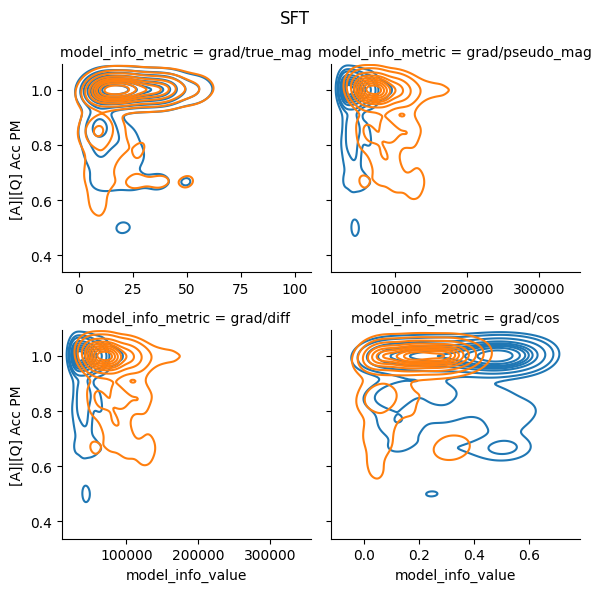

In [ ]:
g = sns.FacetGrid(
    correlation_df,
    col="model_info_metric",
    col_wrap=2,
    hue="tag", palette=color_dict,
    sharex=False
)
g.map(sns.kdeplot, "model_info_value", end_eval_metric,)
plt.suptitle(edit_loss.upper())
plt.tight_layout()
plt.show()

In [109]:
len(io.load_json("/data/users/zliu/malmen/malmen_data/zsre/zsre_eval.json"))

19086

In [110]:
19086 / 37

515.8378378378378

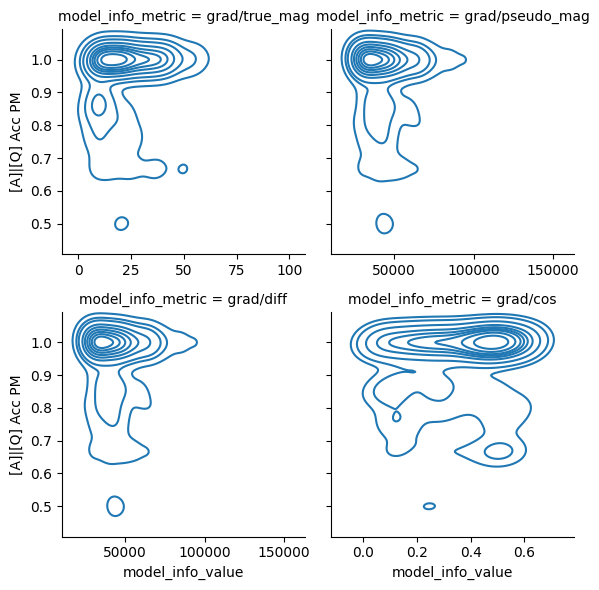

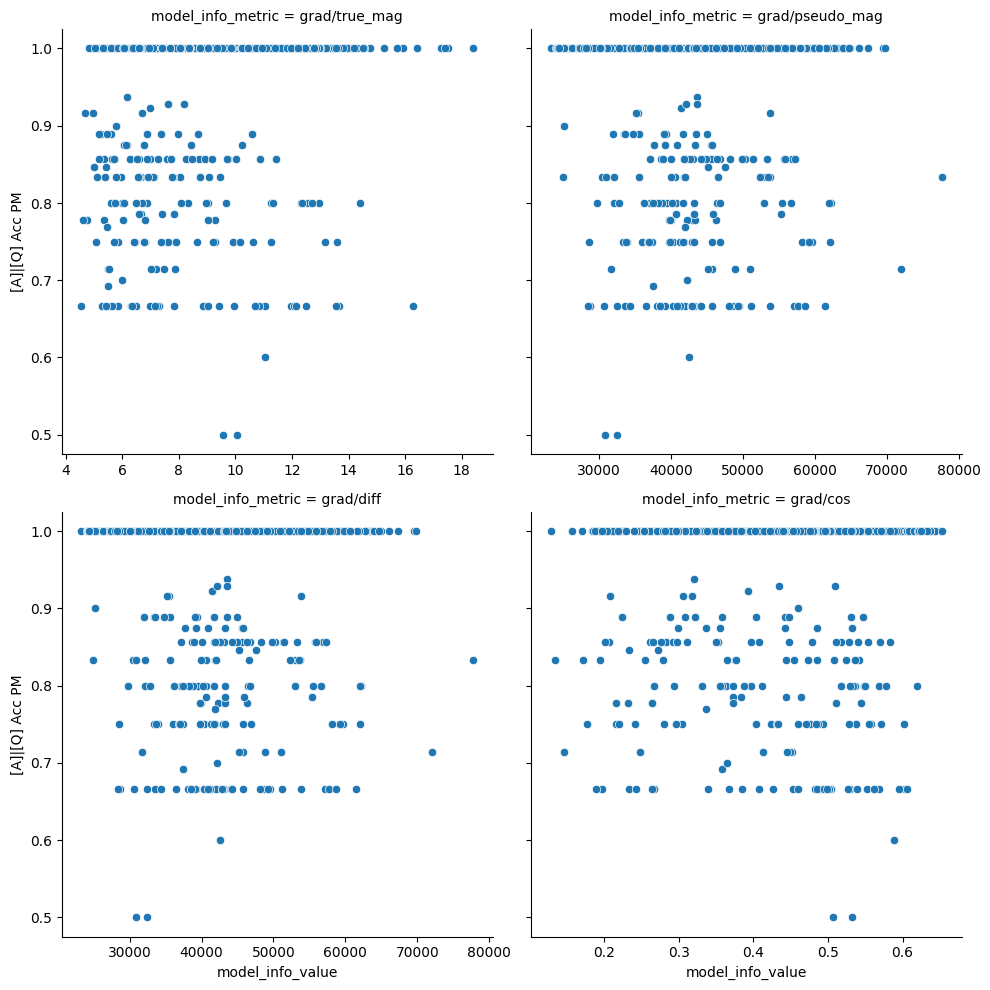

In [40]:
# sns.relplot(
#     data=correlation_df,
#     x="model_info_value", 
#     y=end_eval_metric, 
#     col="model_info_metric", 
#     col_wrap=2,
#     facet_kws={ 'sharex': False}
# )

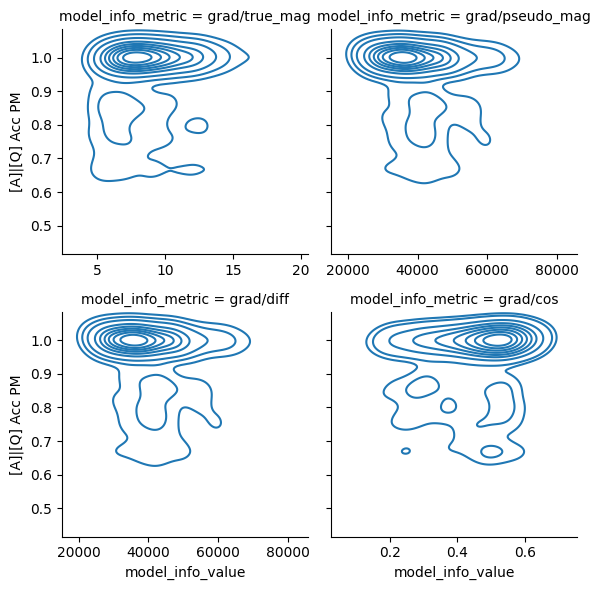